In [ ]:
import numpy as np
from sklearn import preprocessing, cross_validation, svm
import pandas as pd
df = pd.read_csv('breast-cancer-wisconsin.data.txt')
df.replace('?', -99999, inplace=True)
df.drop(['id'],1,inplace=True)

X = np.array(df.drop(['class'],1))
y = np.array(df['class'])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size = 0.2)

clf = svm.SVC()
clf.fit = clf.score(X_test,y_test)

accuracy = clf.score(X_test,y_test)
print(accuracy)

example_measures = np.array([4,2,1,1,1,2,3,2,1])
example_measures = example_measures.reshape(len(example_measures),-1)

prediction = clf.predict(example_measures)
print(prediction)


Optimized a step.
Optimized a step.
Optimized a step.


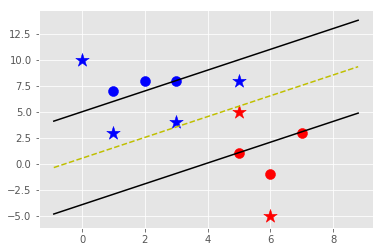

In [6]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
style.use('ggplot')

class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    # train        
    def fit(self, data):
        self.data = data
        # {|w|:[w,b]}
        opt_dict = {}
        
        transforms = [[1,1],[-1,1],[-1,-1],[1,-1]]
        
        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)
        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        all_data = None
        
        step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,
                      # point of expense
                      self.max_feature_value * 0.001]
        # extremely expensive
        b_range_multiple = 5
        # we dont need to take as small of steps with b as we do with w
        b_multiple = 5
        
        latest_optimum = self.max_feature_value * 10
        
        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            # we can do this because convex
            optimized = False
            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        # weakest link in the SVM fundemantally
                        # SMO attamps to fix this a bit
                        # yi (xi . w + b)>=1
                        for i in self.data:
                            for xi in self.data[i]:
                                yi = i
                                if not yi*(np.dot(w_t,xi)+b) >= 1:
                                    found_option = False
                                    break
                            if not found_option:
                                break
                        if found_option:
                            opt_dict[np.linalg.norm(w_t)] = [w_t,b]
                                
                if w[0] < 0:
                    optimized = True
                    print('Optimized a step.')
                else:
                    w = w - [step,step]
            norms = sorted([n for n in opt_dict])
            opt_choice = opt_dict[norms[0]]
            
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0]+step*2
        
    def predict(self, features):
        #sign(x.w+b)
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)
        if classification !=0 and self.visualization:
            self.ax.scatter(features[0],features[1],s = 200, marker = '*', c = self.colors[classification])
        return classification
    def visualize(self):
        [[self.ax.scatter(x[0],x[1],s=100,color=self.colors[i]) for x in data_dict[i]]for i in data_dict]
        def hyperplane(x,w,b,v):
            return (-w[0]*x-b+v) / w[1]
        datarange = [self.min_feature_value*0.9,self.max_feature_value*1.1]
        hyp_x_min = datarange[0]
        hyp_x_max = datarange[1]
        
        psv1 = hyperplane(hyp_x_min, self.w,self.b,1)
        psv2 = hyperplane(hyp_x_max, self.w,self.b,1)
        self.ax.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'k')
        
        ngv1 = hyperplane(hyp_x_min, self.w,self.b,-1)
        ngv2 = hyperplane(hyp_x_max, self.w,self.b,-1)
        self.ax.plot([hyp_x_min,hyp_x_max],[ngv1,ngv2], 'k')
        
        db1 = hyperplane(hyp_x_min, self.w,self.b,0)
        db2 = hyperplane(hyp_x_max, self.w,self.b,0)
        self.ax.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--')
        plt.show()
data_dict = {-1:np.array([[1,7],
                          [2,8],
                          [3,8]]),
            1:np.array([[5,1],
                          [6,-1],
                          [7,3]])}
svm = Support_Vector_Machine()
svm.fit(data = data_dict)

predict_us = [[0,10],[1,3],[3,4],[5,5],[6,-5],[5,8]]
for p in predict_us:
    svm.predict(p)

svm.visualize()

In [9]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x1, x2, p=3):
    return (1+np.dot(x1, x2)) ** p

def gaussian_kernel(x1, x2, sigma=5.0):
    return np.exp(-linalg.norm(x1-x2)**2 / (2 * (sigma ** 2)))

class SVM(object):
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)
            
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Gram matrix
        K = np.zeros((n_samples,n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])
                
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0,0)
        
        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(np_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1,tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1,tmp2)))
        
        # solve QP problem
        solution = cvxopt.solvers.qp[P, q, G, h, A, b]
        
        # Lagrange multipliers
        a = np.ravel(solution['x'])
        
        # Support vectors ave non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))
        
        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)
        
        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y * self.sv[n]
                
        else:
            self.w = None
    
    def project(self,X):
        if self.w is not None:
            return np.dot(X, self.W) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_u, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict = s
            return y_predict + self.b
    
    def predict(self, X):
        return np.sign(self.project(X))
import pylab as p1

def gen_lin_seperable_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8,0.6],[0.6,0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2))
    return X1, y1, X2, y2

def gen_non_lin_seperable_data():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    X1 = np.vstack((X1, npp.random.multivariate(mean3, cov, 50)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean3, cov, 50)
    X2 = np.vstack((X2, npp.random.multivariate(mean4, cov, 50)))
    y2 = np.ones(len(X2))
    return X1, y1, X2, y2

def gen_lin_seperable_overlap_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[1.5,1.0],[1.0,1.5]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2))
    return X1, y1, X2, y2

def split_train(X1,y1,X2,y2):
    X1_train = X1[:90]
    y1_train = y1[:90]
    X2_train = X2[:90]
    y2_train = y2[:90]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    return X_train, y_train

def split_test(X1,y1,X2,y2):
    X1_test = X1[90:]
    y1_test = y1[90:]
    X2_test = X2[90:]
    y2_test = y2[90:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_test, y_test
def plot_margin(X1_train, X2_train, clf):
    def f(x,w,b,c=0):
        # given x, return y such that [x,y] is on the line
        # w.x + b = c
        return (-w[0] * x - b +c) / w[1]
    p1.plot(X1_train[:,0], X1_train[:,1], "ro")
    p1.plot(X2_train[:,0], X2_train[:,1], "bo")
    p1.scatter(clf.sv[:,0], clf.sv[:,1], s =100, c="g")
    
    # w.x + b = 0
    a0 = -4; al = f(a0,clf.w, clf.b)
    b0 = 4; b1 = f(b0,clf.w,clf.b)
    p1.plot([a0,b0],[a1,b1], "k")
    
    # w.x + b = 1
    a0 = -4; al = f(a0,clf.w, clf.b,1)
    b0 = 4; b1 = f(b0,clf.w,clf.b,1)
    p1.plot([a0,b0],[a1,b1], "k--")
    
    # w.x + b = -1
    a0 = -4; al = f(a0,clf.w, clf.b,-1)
    b0 = 4; b1 = f(b0,clf.w,clf.b,-1)
    p1.plot([a0,b0],[a1,b1], "k--")
    
    p1.axis("tight")
    p1.show()
def plot_contour(X1_train, X2_train,clf):
    p1.plot(X1_train[:,0], X1_train[:,1], "ro")
    p1.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s =100, c="g")
    
    X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
    X = np.array([[x1, x2] for x1,x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z=clf.project(X).reshape(X1.shape)
    p1.contour(X1, X2, Z, [0,0], colors = 'k', linewidth=1, origin='lower')
    p1.contour(X1, X2, Z+1, [0,0], colors = 'grey', linewidth=1, origin='lower')
    p1.contour(X1, X2, Z-1, [0,0], colors = 'grey', linewidth=1, origin='lower')
    
    p1.axis("tight")
    p1.show()
    
def test_linear():
    X1, y1, X2, y2 = gen_lin_seperable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM()
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_margin(X_train[y_train==1], X_train[y_train == -1], clf)

def test_non_linear():
    X1, y1, X2, y2 = gen_non_lin_seperable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM(polynomial_kernel)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train == -1], clf)

def test_soft():
    X1, y1, X2, y2 = gen_lin_seperable_overlap_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM(C=1000.1)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train == -1], clf)

test_linear()
#test_non_linear()
#test_soft()

ImportError: No module named 'cvxopt'